In [1]:
# Import dependencies
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import timedelta
from time import time

from keras import optimizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import load_model, Model
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings(action='ignore')  # filter all warnings, in particular ConversionWarning (by numpy)

# Constants
AMPL_THRESH = 2  # Amplitude threshold
BANDS = 32  # Number of frequency bands
FREQ_THRESH = 512  # Frequency threshold
MU = 0.05  # Mean for adding noise from Gaussian distribution
N_FREQ = 12  # Numbers of frequencies
OVERLAP_SIZE = 20  # Number of overlapping rows for sliding window
SIGMA = 0.02  # Standard deviation for adding noise from Gaussian distribution
SLICE_SIZE = 40  # Number of rows which build one sample


Using TensorFlow backend.


# Read and clean data

Input data has the format:
- 0th element - 12 - service information
- [1-13) - Amplitudes of the first axis
- [13-25) - Frequencies of the first axis
- [25-37) - Amplitudes of the second axis
- [37-49) - Frequencies of the second axis

Raw data example:

<img src="./illustrations/raw_data_example.png" width="1300" height="900" align=left>


In [2]:
# Helper functions
def clean_data(data, n_freq=12, 
               freq_flag=True, freq_thresh=512,
               ampl_flag=True, ampl_thresh=2):
    """Delete rows from the data where frequency more than frequency threshold.
       Change amplitude which are more than amplitude threshold to threshold.
    """
    
    data_copied = data[:, 1:].copy()  # do not include 1st column
    
    if freq_flag:
        data_freq = data_copied[:, list(range(n_freq, 2*n_freq)) + list(range(3*n_freq, 4*n_freq))]
        mask = (data_freq <= freq_thresh).all(axis=1)   
        data_copied = data_copied[mask, :]
    
    if ampl_flag:
        part1 = data_copied[:, list(range(0, n_freq))]  # amplitude
        part2 = data_copied[:, list(range(n_freq, 2*n_freq))]  # frequency
        part3 = data_copied[:, list(range(2*n_freq, 3*n_freq))]  # amplitude
        part4 = data_copied[:, list(range(3*n_freq, 4*n_freq))]  # frequency
        part1[part1 > ampl_thresh] = ampl_thresh
        part3[part3 > ampl_thresh] = ampl_thresh    
        data_copied = np.hstack((part1, part2, part3, part4))
        
    return data_copied


def check_data_quality(data, n_freq=12, freq_thresh=512, ampl_thresh=2):
    """Show statistics for rows where 
       frequencies and amplitudes more than threshold.
    """
    
    data_ampl = data[:, [list(range(0, n_freq)) + list(range(2*n_freq, 3*n_freq))]]
    outliers = data_ampl[data_ampl > ampl_thresh]
    if len(outliers) > 0:
        print(f"Amplitude outliers (> {ampl_thresh}): {stats.describe(outliers)}")
    else:
        print("There is no amplitude outliers")
    
    data_freq = data[:, [list(range(n_freq, 2*n_freq)) + list(range(3*n_freq, 4*n_freq))]]
    outliers = data_freq[data_freq > freq_thresh]
    if len(outliers) > 0:
        print(f"Frequency outliers (> {freq_thresh}): {stats.describe(outliers)}")
    else:
        print("There is no frequency outliers")


def get_stats(data, n_freq=12, figsize=(10, 6)):
    """Plot histograms for frequencies and amplitudes."""
    
    fig, ax = plt.subplots(3, 2, figsize=figsize)
    
    frequency = data[:, [list(range(n_freq, 2*n_freq))]].flatten()
    print(f"Stats for frequency axis 1: {stats.describe(frequency)}")
    ax[0][0].hist(frequency, density=True)
    ax[0][0].set_title('Frequency axis 1')

    amplitude = data[:, [list(range(0, n_freq))]].flatten()
    print(f"Stats for amplitude axis 1: {stats.describe(amplitude)}")
    ax[1][0].hist(amplitude, density=True)
    ax[1][0].set_title('Amplitude axis 1')
      
    frequency = data[:, [list(range(3*n_freq, 4*n_freq))]].flatten()
    print(f"Stats for frequency axis 2: {stats.describe(frequency)}")
    ax[0][1].hist(frequency, density=True)
    ax[0][1].set_title('Frequency axis 2')

    amplitude = data[:, [list(range(2*n_freq, 3*n_freq))]].flatten()
    print(f"Stats for amplitude axis 2: {stats.describe(amplitude)}")
    ax[1][1].hist(amplitude, density=True)
    ax[1][1].set_title('Amplitude axis 2')
   
    freq_ampl = frequency * amplitude
    print(f"Stats for freq * ampl axis 1: {stats.describe(freq_ampl)}")
    ax[2][0].hist(freq_ampl, density=True)
    ax[2][0].set_title('Freq * ampl axis 1')    

    freq_ampl = frequency * amplitude
    print(f"Stats for freq * ampl axis 2: {stats.describe(freq_ampl)}")
    ax[2][1].hist(freq_ampl, density=True)
    ax[2][1].set_title('Freq_ampl axis 2')    
    
    fig.tight_layout()


def plot_single_row(data, row=0, n_freq=12, figsize=(10, 6)):
    """Plot single row from data."""
    
    amplitude1 = data[row][0:n_freq]
    frequency1 = data[row][n_freq:2*n_freq]
    
    amplitude2 = data[row][2*n_freq:3*n_freq]    
    frequency2 = data[row][3*n_freq:4*n_freq]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.stem(frequency1, amplitude1)
    ax1.set_title('Axis 1')
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('Amplitude')

    ax2.stem(frequency2, amplitude2)
    ax2.set_title('Axis 2')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Amplitude')
    
    fig.tight_layout()


def plot_comparison(data1, data2, figsize=(14, 6)): 
    """Plot 2 histograms with each other."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=True)
    ax1.hist(data1)
    ax2.hist(data2)
    fig.tight_layout()    



In [3]:
# Read data
print("Reading data...")
t1 = time()
DATA_PATH = r'C:\Users\se.vi.dmitriev\.IdeaIC2019.2\config\scratches\dev1_lba0_261884.txt'
raw_data = np.genfromtxt(fname=DATA_PATH, dtype=np.float64, delimiter=',', invalid_raise=False)
print(f"Finished reading data in {timedelta(seconds=time()-t1)}")

raw_data[0:1]  # Show some data for sense


Reading data...
Finished reading data in 0:00:25.857881


array([[1.2000000e+01, 5.0000000e-01, 2.5781643e-01, 1.2500954e-01,
        1.2500190e-01, 1.3281453e-01, 1.2506294e-01, 1.2536812e-01,
        9.0333410e-03, 0.0000000e+00, 0.0000000e+00, 8.7891970e-03,
        8.8654915e-03, 5.1200000e+01, 3.9200000e+01, 0.0000000e+00,
        1.0240000e+02, 5.4400000e+01, 2.6200000e+01, 5.1400000e+01,
        0.0000000e+00, 7.8400000e+01, 1.2800000e+01, 0.0000000e+00,
        1.2000000e+01, 5.0000000e-01, 3.7701990e-01, 2.5195697e-01,
        2.5586328e-01, 2.5001907e-01, 2.5000380e-01, 0.0000000e+00,
        9.3751430e-02, 6.6437780e-02, 6.2989240e-02, 6.4759290e-02,
        0.0000000e+00, 2.7200000e+01, 5.2800000e+01, 4.2580000e+02,
        1.6000000e+00, 0.0000000e+00, 0.0000000e+00, 6.0000000e+00,
        2.2000000e+00, 0.0000000e+00, 2.0000000e-01, 3.8400000e+01,
        0.0000000e+00]])

In [4]:
# Check quality of the raw data
print("Checking quality of the raw data...")
t1 = time()
check_data_quality(raw_data[:, 1:], n_freq=N_FREQ, freq_thresh=FREQ_THRESH, ampl_thresh=AMPL_THRESH)
print(f"Finished checking quality in {timedelta(seconds=time()-t1)}")

# Clean data
print("\nCleaning data...")
t1 = time()
data = clean_data(raw_data, n_freq=N_FREQ, freq_flag=True, freq_thresh=FREQ_THRESH, ampl_flag=True, ampl_thresh=AMPL_THRESH)
print(f"Finished cleaning data in {timedelta(seconds=time()-t1)}")

# Check quality of the cleaned data
print("\nChecking quality of the cleaned data...")
t1 = time()
check_data_quality(data, n_freq=N_FREQ, freq_thresh=FREQ_THRESH, ampl_thresh=AMPL_THRESH)
print(f"Finished checking quality in {timedelta(seconds=time()-t1)}")

data[0:1]  # Show some data for sense


Checking quality of the raw data...
Amplitude outliers (> 2): DescribeResult(nobs=6308, minmax=(2.000023, 8191.875), mean=282.28043977213065, variance=682654.7375458442, skewness=5.173402290275767, kurtosis=35.66494832997203)
Frequency outliers (> 512): DescribeResult(nobs=1029, minmax=(512.2, 6553.5), mean=1971.6460641399417, variance=1810365.4664363423, skewness=1.4193551849340098, kurtosis=2.253682508441697)
Finished checking quality in 0:00:00.468391

Cleaning data...
Finished cleaning data in 0:00:00.991948

Checking quality of the cleaned data...
There is no amplitude outliers
There is no frequency outliers
Finished checking quality in 0:00:00.153402


array([[5.0000000e-01, 2.5781643e-01, 1.2500954e-01, 1.2500190e-01,
        1.3281453e-01, 1.2506294e-01, 1.2536812e-01, 9.0333410e-03,
        0.0000000e+00, 0.0000000e+00, 8.7891970e-03, 8.8654915e-03,
        5.1200000e+01, 3.9200000e+01, 0.0000000e+00, 1.0240000e+02,
        5.4400000e+01, 2.6200000e+01, 5.1400000e+01, 0.0000000e+00,
        7.8400000e+01, 1.2800000e+01, 0.0000000e+00, 1.2000000e+01,
        5.0000000e-01, 3.7701990e-01, 2.5195697e-01, 2.5586328e-01,
        2.5001907e-01, 2.5000380e-01, 0.0000000e+00, 9.3751430e-02,
        6.6437780e-02, 6.2989240e-02, 6.4759290e-02, 0.0000000e+00,
        2.7200000e+01, 5.2800000e+01, 4.2580000e+02, 1.6000000e+00,
        0.0000000e+00, 0.0000000e+00, 6.0000000e+00, 2.2000000e+00,
        0.0000000e+00, 2.0000000e-01, 3.8400000e+01, 0.0000000e+00]])

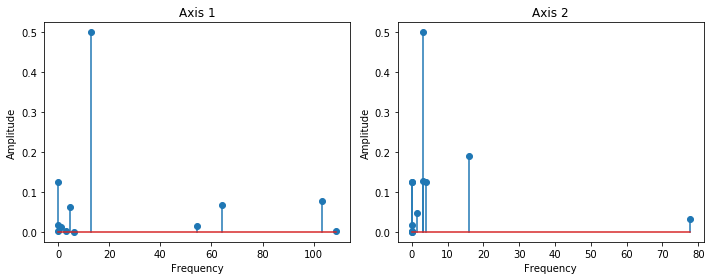

In [5]:
plot_single_row(data, row=12, n_freq=N_FREQ, figsize=(10, 4))


Stats for frequency axis 1: DescribeResult(nobs=6259428, minmax=(0.0, 512.0), mean=93.28248467751366, variance=8937.506969574348, skewness=1.313172615662614, kurtosis=1.540975151941601)
Stats for amplitude axis 1: DescribeResult(nobs=6259428, minmax=(0.0, 2.0), mean=0.42043363399871436, variance=0.01615900254732338, skewness=0.4344066021268336, kurtosis=14.85761531915545)
Stats for frequency axis 2: DescribeResult(nobs=6259428, minmax=(0.0, 512.0), mean=182.24208379743322, variance=33275.9268342574, skewness=0.5913491036714447, kurtosis=-1.3349704287572555)
Stats for amplitude axis 2: DescribeResult(nobs=6259428, minmax=(0.0, 2.0), mean=0.4345578767312166, variance=0.018099188333257858, skewness=0.6416515670391649, kurtosis=14.257920042018348)
Stats for freq * ampl axis 1: DescribeResult(nobs=6259428, minmax=(0.0, 1022.0), mean=84.86062778916018, variance=8560.480935689424, skewness=1.0832001291064688, kurtosis=1.3517584547735852)
Stats for freq * ampl axis 2: DescribeResult(nobs=62594

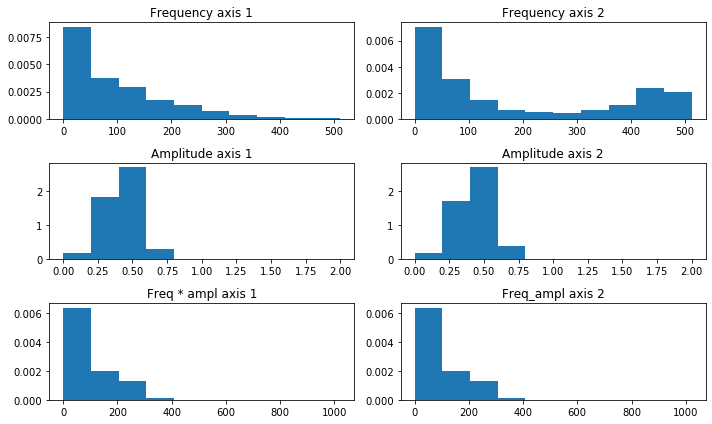

In [6]:
get_stats(data, n_freq=N_FREQ, figsize=(10, 6))

# Generate and transform data samples
A data sample - data during 20s window, so 40 records in a raw data (each raw data is generated each 0.5s)

In [8]:
def generate_samples(data, slice_size=40, overlap_size=20,
                     transform=False, n_freq=12, low_freq=0, high_freq=512, num_bands=5,
                     data_augmentation=False, n_times=1, mu=0.05, sigma=0.02):
    """Returns data samples in format (N, slice_size, num ampl and freq), where N - number of examples.
       If 'transform' is True then transform data in a form of table: rows - time, columns - frequency bands.
       if 'data_augmentation' is True then generate new data with noise.
    """
    
    output = []
    current_idx = 0
    while (current_idx + slice_size) <= len(data):
        output.append(data[current_idx: current_idx+slice_size])
        current_idx = current_idx + slice_size - overlap_size
    
    # Transform data in a form of table: rows - time, columns - frequency bands
    if transform:
        output_trans = []

        # Create bins for frequency bands
        bins_freq = np.linspace(low_freq, high_freq, num_bands+1)

        for i, sample in enumerate(output, 1):
            rows = []  # transformed raw records
            for record in sample:
                row = np.zeros(shape=num_bands*2)

                df_ax1 = pd.DataFrame({'ax1_ampl': record[0:n_freq],
                                       'ax1_freq': record[n_freq:2*n_freq]})

                df_ax2 = pd.DataFrame({'ax2_ampl': record[2*n_freq:3*n_freq],
                                       'ax2_freq': record[3*n_freq:4*n_freq]})

                df_ax1['band'] = np.digitize(df_ax1['ax1_freq'], bins_freq, right=True)
                df_ax2['band'] = np.digitize(df_ax2['ax2_freq'], bins_freq, right=True)

                df_ax1_grouped = df_ax1.groupby(by=['band']).mean()['ax1_ampl']
                df_ax2_grouped = df_ax2.groupby(by=['band']).mean()['ax2_ampl']

                for idx, value in df_ax1_grouped.items():
                    row[idx-1] = value

                for idx, value in df_ax2_grouped.items():
                    row[num_bands+idx-1] = value

                rows.append(row)
                
            output_trans.append(rows)
                                
            if i % 5000 == 0:
                print(f"{i} samples are ready")
            
        result_ini = np.array(output_trans)
        result = result_ini.copy()

        if data_augmentation:
            for i in range(n_times):
                addition = np.clip(result_ini + np.random.normal(mu, sigma, size=result_ini.shape), a_min=0, a_max=None)
                result = np.concatenate((result, addition), axis=0)

    else:
        result_ini = np.array(output)
        result = result_ini.copy()

        if data_augmentation:
            for i in range(n_times):
                addition = np.clip(result_ini + np.random.normal(mu, sigma, size=result_ini.shape), a_min=0, a_max=None)
                result = np.concatenate((result, addition), axis=0)

    return result


In [9]:
print("Generating samples...")
t1 = time()
X = generate_samples(data, slice_size=SLICE_SIZE, overlap_size=OVERLAP_SIZE,
                     transform=True, n_freq=N_FREQ, low_freq=0, high_freq=FREQ_THRESH, num_bands=BANDS,
                     data_augmentation=True, n_times=1, mu=MU, sigma=SIGMA)

print(f"Finished generating samples in {timedelta(seconds=time()-t1)}")

print(f"Shape: {X.shape}")

np.save(f"samples_transf_{BANDS}bands_augment.npy", X)

X[0:1]  # Show some data for sense


Generating samples...
5000 samples are ready
10000 samples are ready
15000 samples are ready
20000 samples are ready
25000 samples are ready
Finished generating samples in 1:00:25.144852
Shape: (52158, 40, 64)


array([[[0.00443275, 0.12506294, 0.25781643, ..., 0.        ,
         0.        , 0.04761069],
        [0.08875155, 0.        , 0.        , ..., 0.        ,
         0.        , 0.12940413],
        [0.08854683, 0.00195315, 0.        , ..., 0.        ,
         0.        , 0.12781465],
        ...,
        [0.06746157, 0.        , 0.        , ..., 0.        ,
         0.        , 0.0315011 ],
        [0.10084077, 0.12526894, 0.2500038 , ..., 0.        ,
         0.        , 0.10457517],
        [0.1142443 , 0.26526741, 0.        , ..., 0.        ,
         0.        , 0.25001907]]])

In [3]:
print("Loading saved samples...")
t1 = time()
X_load = np.load('samples_transf_32bands_augment.npy')
print(f"Finished loading samples in {timedelta(seconds=time()-t1)}")

print(X_load.shape)
X_load[0:1]  # Show some data for sense


Loading saved samples...
Finished loading samples in 0:00:02.698769
(52158, 40, 64)


array([[[0.00443275, 0.12506294, 0.25781643, ..., 0.        ,
         0.        , 0.04761069],
        [0.08875155, 0.        , 0.        , ..., 0.        ,
         0.        , 0.12940413],
        [0.08854683, 0.00195315, 0.        , ..., 0.        ,
         0.        , 0.12781465],
        ...,
        [0.06746157, 0.        , 0.        , ..., 0.        ,
         0.        , 0.0315011 ],
        [0.10084077, 0.12526894, 0.2500038 , ..., 0.        ,
         0.        , 0.10457517],
        [0.1142443 , 0.26526741, 0.        , ..., 0.        ,
         0.        , 0.25001907]]])

# Autoencoder

## CNN Reverse augm 32 freq bands 1 channel simple Relu output

In [4]:
print("Training autoencoder...")
t1 = time()
CHANNELS = 1
np.random.seed(1234)


def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1)."""
    return np.reshape(X, newshape=(-1, X.shape[1], X.shape[2], 1))


# Divide data
X_train, X_test, Y_train, Y_test = train_test_split(X_load, X_load, test_size=0.2, shuffle=True)

X_train = transform_shape(X_train)
print(X_train.shape)

# Create model
input_sample = Input(shape=(X_train.shape[1], X_train.shape[2], CHANNELS))
# Encoder
activation='relu'
x = Conv2D(64, (3, 3), activation=activation, padding='same')(input_sample)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation=activation, padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation=activation, padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation=activation, padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(CHANNELS, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(input_sample, decoded)
print(autoencoder.summary())
optimizer = optimizers.Adam(decay=1e-5)
autoencoder.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_split=0.15, verbose=1)
autoencoder.save(f"autoencoder_rev_augm_32bands_1channel_simple_relu.h5")

print(f"Finished training autoencoder in {timedelta(seconds=time()-t1)}")


Training autoencoder...
(41726, 40, 64, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 64, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 16, 32)        9248      
_________________________________________________________________
up_sampling2d_1 

Building histograms...
Finished building histograms in 0:02:26.030317


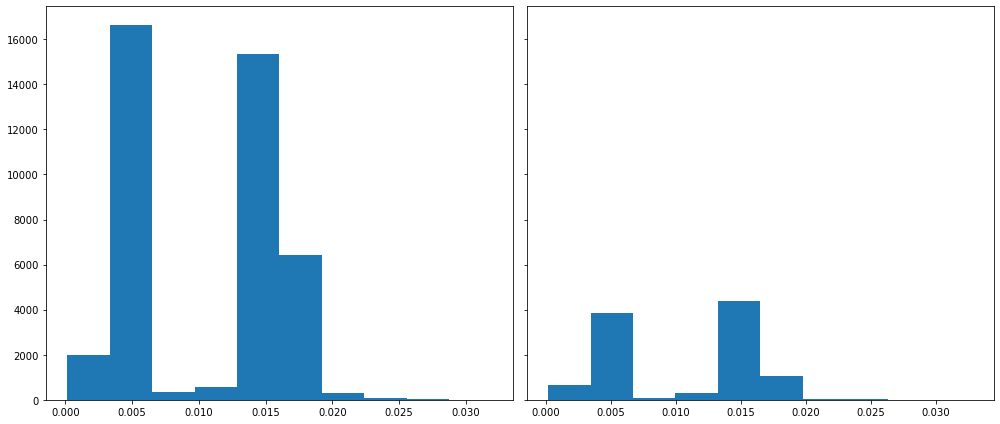

In [5]:
t1 = time()
print("Building histograms...")
losses = [autoencoder.evaluate(X_train[i:i+1], X_train[i:i+1], verbose=0)[0] for i in range(len(X_train))]
X_test = transform_shape(X_test)
losses_test = [autoencoder.evaluate(X_test[i:i+1], X_test[i:i+1], verbose=0)[0] for i in range(len(X_test))]

plot_comparison(losses, losses_test)
print(f"Finished building histograms in {timedelta(seconds=time()-t1)}")


In [10]:
def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1).
    """
    return np.reshape(X, newshape=(-1, X.shape[1], X.shape[2], 1))

y = transform_shape(X_load[0:1])
print(y.shape)
model = load_model('autoencoder_rev_augm_32bands_1channel_simple_relu.h5')
print(model.evaluate(y, y)[0])

z = y.copy()
z[0:1, 1:40, 10:20, 0:1] = 1
print(model.evaluate(z, z)[0])


(1, 40, 64, 1)
1/1 [==============================] - 0s 19ms/step
0.000433782726759091
1/1 [==============================] - 0s 4ms/step
0.011220069602131844


## CNN augm 50 freq bands 1 channel simple Relu output

In [4]:
print("Training autoencoder...")
t1 = time()
CHANNELS = 1
np.random.seed(1234)


def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1)."""
    return np.reshape(X, newshape=(-1, X.shape[1], X.shape[2], 1))


# Divide data
X_train, X_test, Y_train, Y_test = train_test_split(X_load, X_load, test_size=0.2, shuffle=True)

X_train = transform_shape(X_train)
print(X_train.shape)

# Create model
input_sample = Input(shape=(X_train.shape[1], X_train.shape[2], CHANNELS))
# Encoder
activation='relu'
x = Conv2D(16, (3, 3), activation=activation, padding='same')(input_sample)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation=activation, padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(64, (3, 3), activation=activation, padding='same')(x)
#encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation=activation, padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation=activation, padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Conv2D(16, (3, 3), activation=activation, padding='same')(x)
#x = UpSampling2D((2, 2))(x)
decoded = Conv2D(CHANNELS, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(input_sample, decoded)
print(autoencoder.summary())
optimizer = optimizers.Adam(lr=1e-5)
autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_split=0.15, verbose=1)
autoencoder.save(f"autoencoder_augm_50bands_1channel_simple_relu.h5")

print(f"Finished training autoencoder in {timedelta(seconds=time()-t1)}")


Training autoencoder...
(41726, 40, 100, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 100, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 100, 16)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 25, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (No

Building histograms...
Finished building histograms in 0:03:50.001638


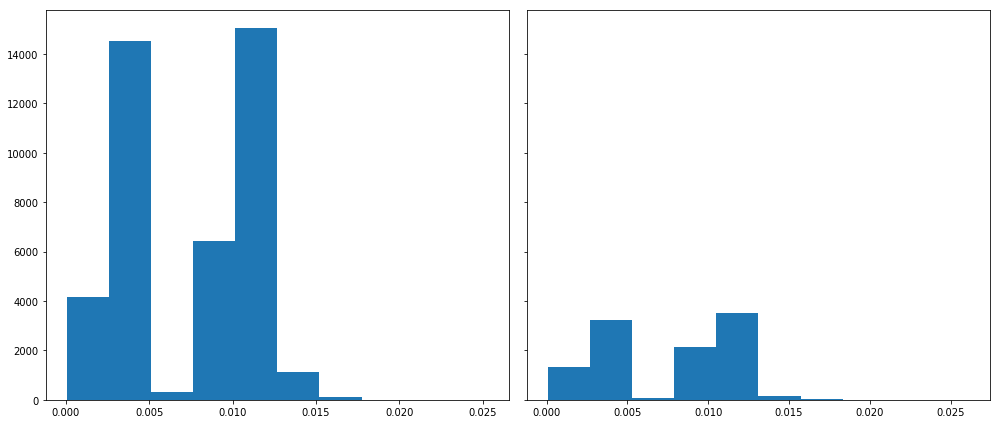

In [5]:
t1 = time()
print("Building histograms...")
losses = [autoencoder.evaluate(X_train[i:i+1], X_train[i:i+1], verbose=0)[0] for i in range(len(X_train))]
X_test = transform_shape(X_test)
losses_test = [autoencoder.evaluate(X_test[i:i+1], X_test[i:i+1], verbose=0)[0] for i in range(len(X_test))]

plot_comparison(losses, losses_test)
print(f"Finished building histograms in {timedelta(seconds=time()-t1)}")


In [8]:
def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1).
    """
    return np.reshape(X, newshape=(-1, X.shape[1], X.shape[2], 1))

y = transform_shape(X_load[0:1])
print(y.shape)
model = load_model('autoencoder_augm_50bands_1channel_simple_relu.h5')
print(model.evaluate(y, y)[0])

z = y.copy()
z[0:1, 1:40, 1:10, 0:1] = 1
print(model.evaluate(z, z)[0])


(1, 40, 100, 1)
1/1 [==============================] - 0s 58ms/step
0.00023300221073441207
1/1 [==============================] - 0s 16ms/step
0.01247255876660347


## CNN augm 50 freq bands 1 channel simple Linear output

In [7]:
print("Training autoencoder...")
t1 = time()
CHANNELS = 1
np.random.seed(1234)


def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1)."""
    return np.reshape(X, newshape=(-1, X.shape[1], X.shape[2], 1))


# Divide data
X_train, X_test, Y_train, Y_test = train_test_split(X_load, X_load, test_size=0.2, shuffle=True)

X_train = transform_shape(X_train)
print(X_train.shape)

# Create model
input_sample = Input(shape=(X_train.shape[1], X_train.shape[2], CHANNELS))
# Encoder
activation='relu'
x = Conv2D(16, (3, 3), activation=activation, padding='same')(input_sample)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation=activation, padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(64, (3, 3), activation=activation, padding='same')(x)
#encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation=activation, padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation=activation, padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Conv2D(16, (3, 3), activation=activation, padding='same')(x)
#x = UpSampling2D((2, 2))(x)
decoded = Conv2D(CHANNELS, (3, 3), activation='linear', padding='same')(x)

autoencoder = Model(input_sample, decoded)
print(autoencoder.summary())
optimizer = optimizers.Adam(lr=1e-5)
autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_split=0.15, verbose=1)
autoencoder.save(f"autoencoder_augm_50bands_1channel_simple_linear.h5")

print(f"Finished training autoencoder in {timedelta(seconds=time()-t1)}")


Training autoencoder...
(41726, 40, 100, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 40, 100, 1)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 40, 100, 16)       160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 50, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 20, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 25, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 10, 25, 64)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (No

Building histograms...
Finished building histograms in 0:04:03.582289


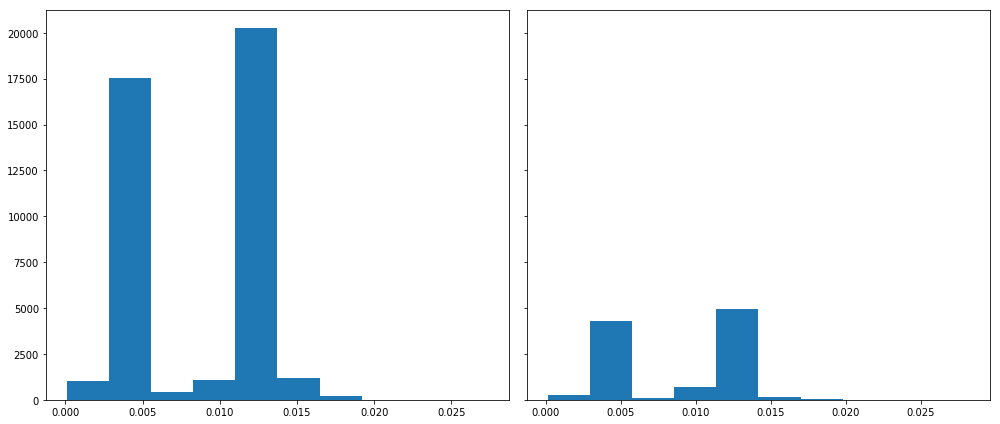

In [13]:
t1 = time()
print("Building histograms...")
losses = [autoencoder.evaluate(X_train[i:i+1], X_train[i:i+1], verbose=0)[0] for i in range(len(X_train))]
X_test = transform_shape(X_test)
losses_test = [autoencoder.evaluate(X_test[i:i+1], X_test[i:i+1], verbose=0)[0] for i in range(len(X_test))]

plot_comparison(losses, losses_test)
print(f"Finished building histograms in {timedelta(seconds=time()-t1)}")


In [9]:
def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1).
    """
    return np.reshape(X, newshape=(-1, X.shape[1], X.shape[2], 1))

y = transform_shape(X_load[0:1])
print(y.shape)
model = load_model('autoencoder_augm_50bands_1channel_simple_linear.h5')
print(model.evaluate(y, y)[0])

z = y.copy()
z[0:1, 1:40, 1:10, 0:1] = 1
print(model.evaluate(z, z)[0])


(1, 40, 100, 1)
1/1 [==============================] - 0s 95ms/step
0.00039312258013524115
1/1 [==============================] - 0s 5ms/step
0.018322641029953957


## CNN augm 50 freq bands 1 channel complex Linear output

In [13]:
print("Training autoencoder...")
t1 = time()
CHANNELS = 1
np.random.seed(1234)


def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1)."""
    return np.reshape(X, newshape=(-1, X.shape[1], X.shape[2], 1))


# Divide data
X_train, X_test, Y_train, Y_test = train_test_split(X_load, X_load, test_size=0.2, shuffle=True)

X_train = transform_shape(X_train)
print(X_train.shape)

# Create model
input_sample = Input(shape=(X_train.shape[1], X_train.shape[2], CHANNELS))
# Encoder
activation='relu'
x = Conv2D(16, (3, 5), activation=activation, padding='same')(input_sample)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation=activation, padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation=activation, padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation=activation, padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (1, 2), activation=activation, padding='valid')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation=activation, padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(CHANNELS, (3, 5), activation='linear', padding='same')(x)

autoencoder = Model(input_sample, decoded)
print(autoencoder.summary())
optimizer = optimizers.Adam(lr=1e-5)
autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_split=0.15, verbose=1)
autoencoder.save(f"autoencoder_augm_50bands_1channel_complex_linear.h5")

print(f"Finished training autoencoder in {timedelta(seconds=time()-t1)}")


Training autoencoder...
(41726, 40, 100, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 40, 100, 1)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 40, 100, 16)       256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 20, 50, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 20, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 25, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 10, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (No

Building histograms...
Finished building histograms in 0:03:22.375171


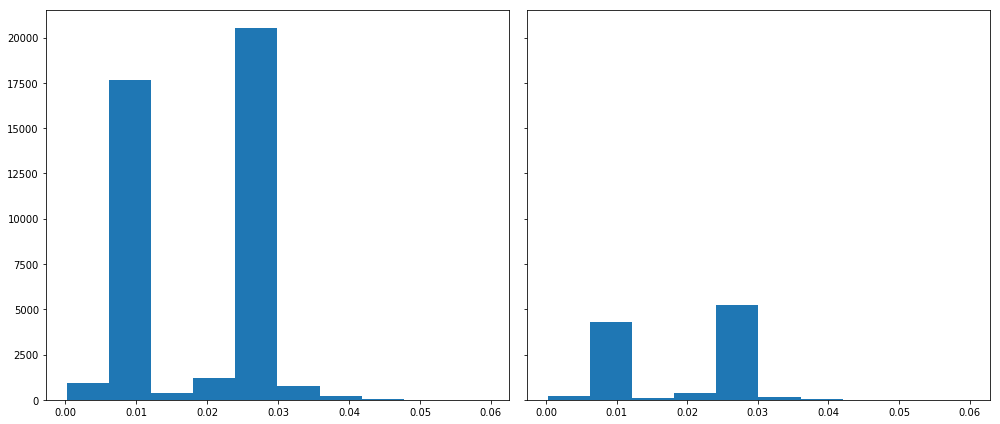

In [14]:
t1 = time()
print("Building histograms...")
losses = [autoencoder.evaluate(X_train[i:i+1], X_train[i:i+1], verbose=0)[0] for i in range(len(X_train))]
X_test = transform_shape(X_test)
losses_test = [autoencoder.evaluate(X_test[i:i+1], X_test[i:i+1], verbose=0)[0] for i in range(len(X_test))]

plot_comparison(losses, losses_test)
print(f"Finished building histograms in {timedelta(seconds=time()-t1)}")


In [10]:
def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1).
    """
    return np.reshape(X, newshape=(-1, X.shape[1], X.shape[2], 1))

y = transform_shape(X_load[0:1])
print(y.shape)
model = load_model('autoencoder_augm_50bands_1channel_complex_linear.h5')
print(model.evaluate(y, y)[0])

z = y.copy()
z[0:1, 1:40, 1:10, 0:1] = 1
print(model.evaluate(z, z)[0])


(1, 40, 100, 1)
1/1 [==============================] - 0s 96ms/step
0.0009964894270524383
1/1 [==============================] - 0s 0us/step
0.009749019518494606


## CNN 50 freq bands 2 channel simple Linear output

In [42]:
t1 = time()
print("Training autoencoder...")
np.random.seed(1234)


def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1)."""
    
    X_freq_ax1 = X[:, :, list(range(0, BANDS))]   
    X_freq_ax2 = X[:, :, list(range(BANDS, 2*BANDS))]
    
    return np.stack((X_freq_ax1, X_freq_ax2), axis=3)


# Divide data
X_train, X_test, Y_train, Y_test = train_test_split(X_load, X_load, test_size=0.2)

X_train = transform_shape(X_train)
print(X_train.shape)

CHANNELS = 2

# Create model
input_sample = Input(shape=(X_train.shape[1], X_train.shape[2], CHANNELS))
# Encoder
activation='relu'
x = Conv2D(16, (3, 3), activation=activation, padding='same')(input_sample)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation=activation, padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(64, (3, 3), activation=activation, padding='same')(x)
#encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation=activation, padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (1, 2), activation=activation, padding='valid')(x)
x = UpSampling2D((2, 2))(x)
#x = Conv2D(16, (3, 3), activation=activation, padding='same')(x)
#x = UpSampling2D((2, 2))(x)
#decoded = Conv2D(CHANNELS, (1, 3), activation='linear', padding='valid')(x)
decoded = Conv2D(CHANNELS, (3, 3), activation='linear', padding='same')(x)

autoencoder = Model(input_sample, decoded)
print(autoencoder.summary())
optimizer = optimizers.Adam(lr=1e-5)
autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, validation_split=0.15, verbose=1)
autoencoder.save(f"autoencoder_50bands_2channel_simple_linear.h5")

print(f"Finished training autoencoder in {timedelta(seconds=time()-t1)}")


Training autoencoder...
(20863, 40, 50, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 40, 50, 2)         0         
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 40, 50, 16)        304       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 20, 25, 16)        0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 20, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 10, 13, 32)        0         
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 10, 13, 64)        18496     
_________________________________________________________________
conv2d_211 (Conv2D)          (Non

Building histograms...
Finished building histograms in 0:01:22.062517


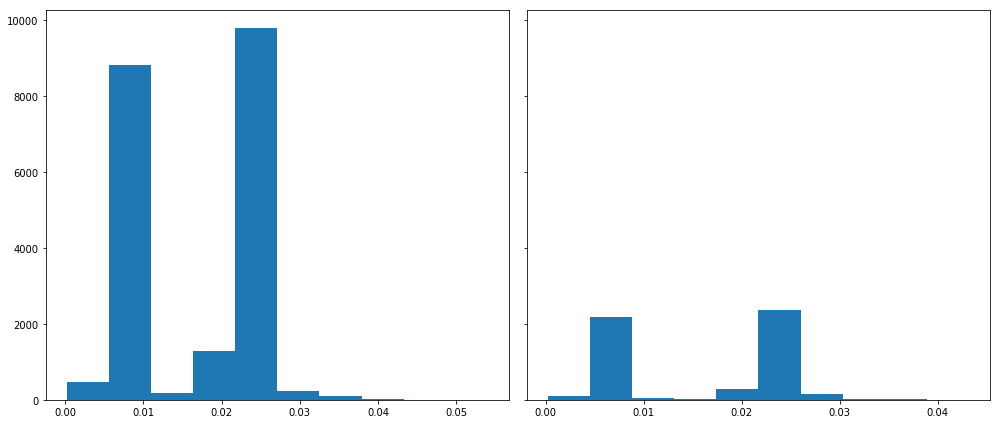

In [43]:
t1 = time()
print("Building histograms...")
losses = [autoencoder.evaluate(X_train[i:i+1], X_train[i:i+1], verbose=0)[0] for i in range(len(X_train))]
X_test = transform_shape(X_test)
losses_test = [autoencoder.evaluate(X_test[i:i+1], X_test[i:i+1], verbose=0)[0] for i in range(len(X_test))]

plot_comparison(losses, losses_test)
print(f"Finished building histograms in {timedelta(seconds=time()-t1)}")


In [11]:
def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1)."""
    
    X_freq_ax1 = X[:, :, list(range(0, BANDS))]   
    X_freq_ax2 = X[:, :, list(range(BANDS, 2*BANDS))]
    
    return np.stack((X_freq_ax1, X_freq_ax2), axis=3)

y = transform_shape(X_load[0:1])
print(y.shape)
model = load_model('autoencoder_50bands_2channel_simple_linear.h5')
print(model.evaluate(y, y)[0])

z = y.copy()
z[0:1, 1:40, 1:2, 0:1] = -1
print(model.evaluate(z, z)[0])


(1, 40, 50, 2)
1/1 [==============================] - 0s 113ms/step
0.00105905847158283
1/1 [==============================] - 0s 0us/step
0.008779962547123432


## CNN nobands 1 channel simple Linear output

In [82]:
t1 = time()
print("Training autoencoder...")
np.random.seed(1234)


def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1).
    """
    return np.reshape(X, newshape=(-1, X.shape[1], X.shape[2], 1))
'''

def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1).
    """
    
    X_ampl = X[:, :, list(range(0, N_FREQ)) + list(range(2*N_FREQ, 3*N_FREQ))]   
    X_freq = X[:, :, list(range(N_FREQ, 2*N_FREQ)) + list(range(3*N_FREQ, 4*N_FREQ))]
    
    return np.stack((X_ampl, X_freq), axis=3)
'''

def normilize(X):
    """Normalize data.
    """
    output = X.copy()
    
    output[:, 0:12] /= 2
    output[:, 12:24] /= 512
    output[:, 24:36] /= 2
    output[:, 36:48] /= 512    
    
    return output


# Divide data
X_train, X_test, Y_train, Y_test = train_test_split(X_load, X_load, test_size=0.2)

#scaler = MinMaxScaler()
#X_train = np.reshape(X_train, newshape=(-1, 48))
#X_train = scaler.fit_transform(X_train)
#X_train = np.reshape(X_train, newshape=(-1, 40, 48))

#X_train = normilize(X_train)
X_train = transform_shape(X_train)
print(X_train.shape)

CHANNELS = 1

# Create model
input_sample = Input(shape=(X_train.shape[1], X_train.shape[2], CHANNELS))
# Encoder
activation='relu'
x = Conv2D(16, (3, 3), activation=activation, padding='same')(input_sample)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation=activation, padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(64, (3, 3), activation=activation, padding='same')(x)
#encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation=activation, padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation=activation, padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Conv2D(16, (3, 3), activation=activation, padding='same')(x)
#x = UpSampling2D((2, 2))(x)
decoded = Conv2D(CHANNELS, (3, 3), activation='linear', padding='same')(x)

autoencoder = Model(input_sample, decoded)
print(autoencoder.summary())
optimizer = optimizers.Adam(lr=1e-5)
autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
autoencoder.fit(X_train, X_train, epochs=30, batch_size=64, validation_split=0.15, verbose=1)
autoencoder.save(f"autoencoder_nobands_1channel_simple_linear.h5")

print(f"Finished training autoencoder in {timedelta(seconds=time()-t1)}")


Training autoencoder...
(20863, 40, 48, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 40, 48, 1)         0         
_________________________________________________________________
conv2d_214 (Conv2D)          (None, 40, 48, 16)        160       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 20, 24, 16)        0         
_________________________________________________________________
conv2d_215 (Conv2D)          (None, 20, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 10, 12, 32)        0         
_________________________________________________________________
conv2d_216 (Conv2D)          (None, 10, 12, 64)        18496     
_________________________________________________________________
conv2d_217 (Conv2D)          (Non

Building histograms...
Finished building histograms in 0:01:36.682405


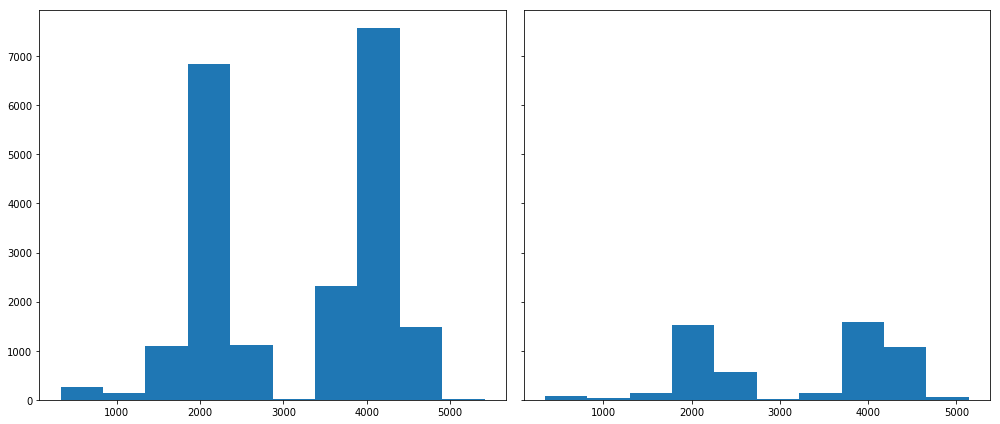

In [83]:
t1 = time()
print("Building histograms...")
losses = [autoencoder.evaluate(X_train[i:i+1], X_train[i:i+1], verbose=0)[0] for i in range(len(X_train))]
X_test = transform_shape(X_test)
losses_test = [autoencoder.evaluate(X_test[i:i+1], X_test[i:i+1], verbose=0)[0] for i in range(len(X_test))]

plot_comparison(losses, losses_test)
print(f"Finished building histograms in {timedelta(seconds=time()-t1)}")


In [15]:
def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1)."""
    return np.reshape(X, newshape=(-1, X.shape[1], X.shape[2], 1))

y = transform_shape(X_load[0:1])
print(y.shape)
model = load_model('autoencoder_nobands_1channel_simple_linear.h5')
print(model.evaluate(y, y)[0])

z = y.copy()
z[0:1, 1:40, 1:12, 0:1] = -1
print(model.evaluate(z, z)[0])


(1, 40, 48, 1)
1/1 [==============================] - 0s 147ms/step
1558.7445068359375
1/1 [==============================] - 0s 16ms/step
1558.4754638671875


## MLP nobands 1 channel simple Linear output

In [20]:
t1 = time()
print("Training autoencoder...")
np.random.seed(1234)


def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1)."""
    return np.reshape(X, newshape=(-1, X.shape[1] * X.shape[2]))


# Divide data
X_train, X_test, Y_train, Y_test = train_test_split(X_load, X_load, test_size=0.2)

X_train = transform_shape(X_train)
print(X_train.shape)

CHANNELS = 1

# Create model
input_sample = Input(shape=(X_train.shape[1],))
# Encoder
activation='relu'
x = Dense(2048, activation=activation)(input_sample)
x = Dense(1024, activation=activation)(x)
encoded = Dense(512, activation=activation)(x)

# Decoder
x = Dense(512, activation=activation)(encoded)
x = Dense(1024, activation=activation)(x)
decoded = Dense(X_train.shape[1], activation=activation)(x)

autoencoder = Model(input_sample, decoded)
print(autoencoder.summary())
optimizer = optimizers.Adam(lr=1e-5)
autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
autoencoder.fit(X_train, X_train, epochs=20, batch_size=128, validation_split=0.15, verbose=1)
autoencoder.save(f"autoencoder_nobands_1channel_simple_linear_mlp.h5")

print(f"Finished training autoencoder in {timedelta(seconds=time()-t1)}")


Training autoencoder...
(20863, 1920)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1920)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              3934208   
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_17 (Dense)             (None, 19

Building histograms...
Finished building histograms in 0:01:34.855526


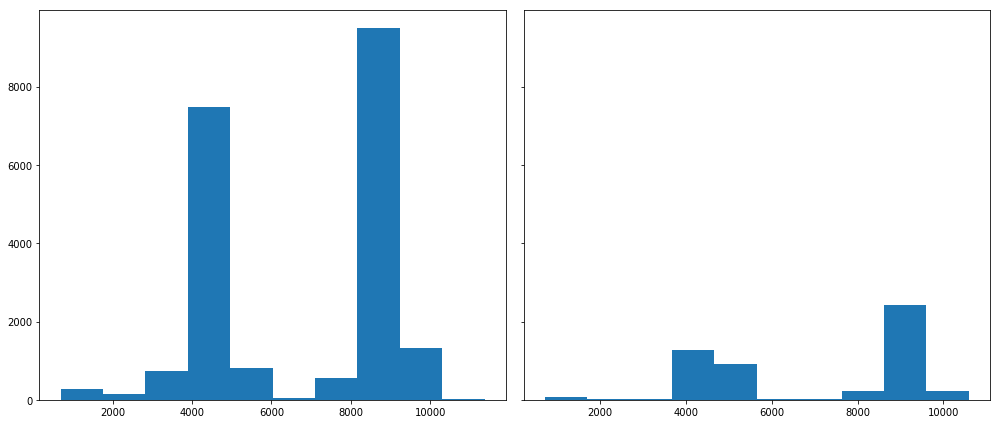

In [21]:
t1 = time()
print("Building histograms...")
losses = [autoencoder.evaluate(X_train[i:i+1], X_train[i:i+1], verbose=0)[0] for i in range(len(X_train))]
X_test = transform_shape(X_test)
losses_test = [autoencoder.evaluate(X_test[i:i+1], X_test[i:i+1], verbose=0)[0] for i in range(len(X_test))]

plot_comparison(losses, losses_test)
print(f"Finished building histograms in {timedelta(seconds=time()-t1)}")

In [24]:
def transform_shape(X):
    """Reshape input data into (-1, num_rows, num_cols, 1)."""
    return np.reshape(X, newshape=(-1, X.shape[1] * X.shape[2]))

y = transform_shape(X_load[0:1])
print(y.shape)
model = load_model('autoencoder_nobands_1channel_simple_linear_mlp.h5')
print(model.evaluate(y, y)[0])

z = y.copy()
z[0:1, 1:200] = 1
print(model.evaluate(z, z)[0])


(1, 1920)
1/1 [==============================] - 0s 234ms/step
2932.374755859375
1/1 [==============================] - 0s 0us/step
2802.52587890625
